# Python Programming for Finance

This notebook includes notes, and examples from the YouTube series by [sentdex](https://www.youtube.com/channel/UCfzlCWGWYyIQ0aLC5w48gBQ), [Python Programming for Finance](https://www.youtube.com/playlist?list=PLQVvvaa0QuDcOdF96TBtRtuQksErCEBYZ).

## Required Packages

* pandas
* pandas-datareader
* matplotlib
* beautifulsoup4
* scikit-learn
* mpl_finance


## Table of Contents

[1. Analyse data from just one company](#intro)

[2. Collect and combine data from the entire S&P 500 companies](#SP)
3. Analyse relationships between companies
4. Formulate trading strategies
5. Analyze trading strategies



## <a class="anchor" id="intro"></a> Intro and Getting Share Price Data 

To begin, we'll collect and analyse the share price data of the electric car company [TESLA](https://www.tesla.com/en_GB/). This was done using the pandas DataReader, and by collecting the data from the financial website https://www.morningstar.com/. 

In [1]:
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web

start = dt.datetime(2000, 1, 1)
end = dt.datetime.now()
df = web.DataReader("TSLA", 'morningstar', start, end)  # Collects data
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
df = df.drop("Symbol", axis=1)

df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2010-06-29,23.89,25.0000,17.54,19.00,18783276
2010-06-30,23.83,30.4192,23.30,25.96,17194394
2010-07-01,21.96,25.9200,20.27,25.00,8216789
2010-07-02,19.20,23.1000,18.71,23.00,5135795
2010-07-05,19.20,19.2000,19.20,19.20,0


In [2]:
df.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2018-07-16,310.10,315.16,306.2500,311.71,7818655
2018-07-17,322.69,324.74,308.5000,308.81,6996232
2018-07-18,323.85,325.50,316.2500,325.00,5624211
2018-07-19,320.23,323.54,314.0100,316.33,5915345
2018-07-20,313.58,323.24,311.7093,321.23,5166547


### Visualize TESLA Close Prices

In [3]:
# Visualize the close prices
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

df.Close.plot()
plt.ylabel('Close Price'); plt.xlabel('Date')
plt.show()

<Figure size 640x480 with 1 Axes>

## Basic Stock Data Manipulation

### Moving Averages

Here we will create [moving averages](https://www.investopedia.com/terms/m/movingaverage.asp) of the TESLA share price data. 

Moving averages are created by averaging over historical price data, and result in a curve that smooths out price over time. They can be useful indicators for traders, particuarly when different moving averages cross as this can indicate an uptrend/ downtrend in price. 

Here we will create and visualize the 100 day moving average, and visualize it along with the close price and volume data. 

In [4]:
# Create, and add 100 day moving average to dataframe
df['100ma'] = df['Close'].rolling(window=100, min_periods=0).mean()
df.head()

,Close,High,Low,Open,Volume,100ma
Date,,,,,,
2010-06-29,23.89,25.0000,17.54,19.00,18783276,23.890000
2010-06-30,23.83,30.4192,23.30,25.96,17194394,23.860000
2010-07-01,21.96,25.9200,20.27,25.00,8216789,23.226667
2010-07-02,19.20,23.1000,18.71,23.00,5135795,22.220000
2010-07-05,19.20,19.2000,19.20,19.20,0,21.616000


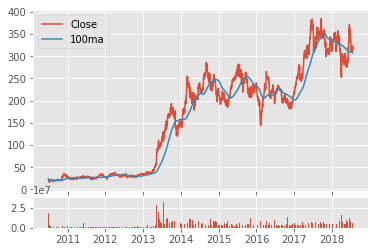

In [5]:
# Visualize the close prices, 100ma, and volume
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

ax1.plot(df.index, df.Close)
ax1.plot(df.index, df['100ma'])
ax2.bar(df.index, df.Volume, label='volume')

ax1.legend()
plt.show()

### Candlestick Charting

Resampling is a very useful operation in Pandas for manipulating time series data. It involves changing the frequency of your time series observations. 

There are two types of resampling:
1. ___Upsampling___: Where you increase the frequency of the samples (e.g. minutes $\rightarrow$ seconds)
2. ___Downsampling___: Where you decrease the frequency of the samples (e.g. days $\rightarrow$ months)

Here we will use resampling to create [candlesticks](https://www.investopedia.com/trading/candlestick-charting-what-is-it/). 

First, we resample our close prices to get the [open-high-low-close](https://www.investopedia.com/terms/o/ohlcchart.asp) (OHLC) data.

In [6]:
# Resample to get open-high-low-close (OHLC) on every 10 days of data
df_ohlc = df.Close.resample('10D').ohlc() 
df_volume = df.Volume.resample('10D').sum()

df_ohlc.head()

,open,high,low,close
Date,,,,
2010-06-29,23.89,23.89,15.80,17.46
2010-07-09,17.40,20.64,17.05,20.64
2010-07-19,21.91,21.91,20.22,20.72
2010-07-29,20.35,21.95,19.59,19.59
2010-08-08,19.60,19.60,17.60,19.15


```matplotlib.finance``` offers some useful functions for plotting candlesticks. 

In [7]:
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

The function ```candlestick_ohlc``` requires a special type of data type known as an mdate. Here, we convert our dates into mdates:

In [8]:
df_ohlc.reset_index(inplace=True)
df_ohlc.Date = df_ohlc.Date.map(mdates.date2num)
df_ohlc.head()

,Date,open,high,low,close
0,733952.0,23.89,23.89,15.80,17.46
1,733962.0,17.40,20.64,17.05,20.64
2,733972.0,21.91,21.91,20.22,20.72
3,733982.0,20.35,21.95,19.59,19.59
4,733992.0,19.60,19.60,17.60,19.15


Having created our open high low close data, we can now use it to create candlesticks:

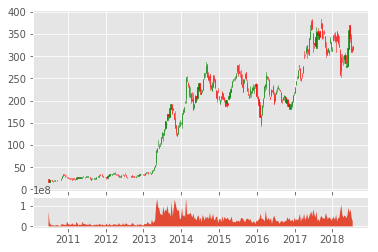

In [9]:
# Create and visualize candlestick charts
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
ax1.xaxis_date()

candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)

plt.show()

Candlestick graphs help condense __price direction__ and __open-high-low-close__ data all in just one graph. In addition, we have plotted the __volume__ in the lower subplot to condense even more information in just one plot.

## <a class="anchor" id="SP"></a> Automating Getting the S&P 500 List

The [S&P 500](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) is a list of (generally) the top 500 companies by _market capitalization_. The market capitilization describes the value of a company, and is calculated as the product of the number of its outstanding shares and the price of each share. The S&P can therefore be thought of as the __top 500 most valuable companies__.

Here we will build create a ___web scraper___ that will collect the S&P data from the internet. To do this, we use a web scraping library called [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/).

By first opening our [website](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) that contains the data we want, we take note of how the data is presented. We observe that it is displayed in a _table_, and the first row second column has a security, '_3M Company_'. What we want is to collect the data that is displayed in this table. To do this, we can extract it from the websites source code. To view the source code we first go to the website, and then press ```CTRL+U``` on the keyboard. By then pressing ```CTRL+F```, we search for the occurence of the first elements in the table (e.g. we search for the term '3M Company'), to get an idea of where the table data begins. By then searching for the term '_table_', we observe an occurence of it only a couple of lines above it. A couple of lines below that, we observe the first table data tags, ```<td>```, this denotes the beginning of the table data that we want to extract.

Let's build the web scraper!

In [10]:
import bs4 as bs  # Beautiful Soup (web scraping library)
import pickle  # Allows us to save S&P list
import requests

The [pickle](https://docs.python.org/2/library/pickle.html) module serializes any Python objects, and allows us to __save any object__ as a variable. Here we will use it to save the S&P 500 list, so that we won't have to always go back to wikipedia to collect that data. 

In [11]:
# Saves the S&P 500 ticker data
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = []
    
    # Iterate through the table
    for row in table.findAll('tr')[1:]:  # [1:] Skips the table header
        ticker = row.findAll('td')[0].text  # Collects the ticker data
        tickers.append(ticker)
    
    # Save the collected data
    with open('sp500tickers.pickle', 'wb') as f:
        pickle.dump(tickers, f)
        
    return tickers

In [12]:
save_sp500_tickers()[:5]  # Print just the first 5 tickers in the table

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN']

Comparing these with the first 5 tickers in the table of our [wikipedia page](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies), we observe they are identical. Having sucesfully scraped the ticker data for our S&P 500 list, we will now collect the rest of the relevant data.

It appears that the morningstar API gets stuck loading a few of the tickers. I have added a try and except code block, so that if it takes too long, interrupt the kernel so that it will continue loading the others.

In [13]:
import os
import time

In [14]:
def get_data_from_web(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.now()
            
    # Check if file already exists as a locally saved file    
    for ticker in tickers:
        try:
            # Collect and save data locally if it doesn't exist yet
            if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
                df = web.DataReader(ticker, 'morningstar', start, end)
                df.reset_index(inplace= True)
                df.set_index('Date', inplace= True)
                df = df.drop('Symbol', axis=1)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
            else:
                print('Already have {}'.format(ticker))  # Already exists
        except:
            print('Cannot obtain data for ' + ticker)  # If it takes too long

In [15]:
get_data_from_web()  # Collect and store all ticker data locally

Cannot obtain data for ANDV
Cannot obtain data for BKNG
Cannot obtain data for BHF
Cannot obtain data for CBRE
Cannot obtain data for DWDP
Cannot obtain data for DXC
Cannot obtain data for EVRG
Cannot obtain data for JEF
Cannot obtain data for TPR
Cannot obtain data for UAA
Cannot obtain data for WELL


https://www.youtube.com/watch?v=j0zW_KXyQJ4&list=PLQVvvaa0QuDcOdF96TBtRtuQksErCEBYZ&index=7

The performance of the S&P can be used as an indicator for roughly how well the economy is doing. Investors commonly refer to the S&P as a benchmark of the overall market, to which all other investments are compared. 

Here we will wr